In [0]:
!pip install --upgrade -q gspreadt
!pip install --upgrade -q plotly
!pip install --upgrade -q sklearn


In [0]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials


gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
import pandas as pd
# Open our new sheet and read some data.
worksheet = gc.open('Fire V2').sheet1

# get_all_values gives a list of rows.
#rows = worksheet.get_all_values()
rows = worksheet.get_all_records()
#print(rows)

# Convert to a DataFrame and render.
#pd.DataFrame.from_records(rows)
#investment_df = pd.DataFrame.from_records(rows)
#print(investment_df.head(5))


***Setting up Dataframe***

In [42]:
import calendar
import plotly
import skimage
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import timedelta

now = datetime.datetime.now()
year0 = now.year
month0 = now.month

year1 = now.year - 1
year2 = now.year - 2


print(year0, month0)


#plotly.__version_

2018 8


In [43]:

#droping the dataframe
investment_df.drop

#Initliazting the dataframe
investment_df = pd.DataFrame.from_records(rows)

#figure out a loop to do this
#insert missing rows for farmcredit
missing_fc_401k_df = pd.DataFrame([[0.00, 'Farm Credit',0.00, 0.00,'2014-01-01','401k'],
                              [0.00, 'Farm Credit',0.00, 0.00,'2014-02-01','401k'],
                              [0.00, 'Farm Credit',0.00, 0.00,'2014-03-01','401k']], 
                             columns=['begin_balance','company','contributions','end_balance','first_of_month','type'])

missing_fc_hsa_df = pd.DataFrame([[0.00, 'Farm Credit',0.00, 0.00,'2014-01-01','HSA'],
                              [0.00, 'Farm Credit',0.00, 0.00,'2014-02-01','HSA'],
                              [0.00, 'Farm Credit',0.00, 0.00,'2014-03-01','HSA'],
                              [0.00, 'Farm Credit',0.00, 0.00,'2014-04-01','HSA']], 
                             columns=['begin_balance','company','contributions','end_balance','first_of_month','type'])




#appending missing with current df
investment_df = investment_df.append(missing_fc_401k_df)
investment_df = investment_df.append(missing_fc_hsa_df)

#convert date column to a datetime format
investment_df['first_of_month'] =  pd.to_datetime(investment_df['first_of_month'], format='%Y-%m-%d')


#adding entries for end of year
missing_month_count = abs( max(investment_df['first_of_month']).month - 12)
missing_date =  max(investment_df['first_of_month']) + pd.DateOffset(months=1)

for m in range(0,missing_month_count):
  print(m)
  missing_date = max(investment_df['first_of_month']) + pd.DateOffset(months=1)
  current_year_missing = pd.DataFrame([[0.00, 'Farm Credit',0.00, 0.00,missing_date,'401k'],
                              [0.00, 'Farm Credit',0.00, 0.00,missing_date,'HSA']], 
                             columns=['begin_balance','company','contributions','end_balance','first_of_month','type'])
  investment_df = investment_df.append(current_year_missing)
 
  

#final re-ordering
investment_df = investment_df.sort_values(['company','type','first_of_month'], ascending=True)


#setting up helper columns
investment_df['tran_year']       = pd.DatetimeIndex(investment_df.first_of_month).year
investment_df['tran_month']      = pd.DatetimeIndex(investment_df.first_of_month).month
investment_df['tran_month_name'] = investment_df['tran_month'].apply(lambda x: calendar.month_abbr[x])
#investment_df['mror']       = (investment_df.end_balance - investment_df.begin_balance)/investment_df.end_balance*100
investment_df['mror']   = np.round((((investment_df.end_balance - investment_df.begin_balance - investment_df.contributions)/(investment_df.end_balance - investment_df.contributions))*100),decimals=3)

#Update NaN values
investment_df['mror'] = investment_df.mror.fillna(0)

#updating outliers
outliers_update = pd.Series([0], name='mror', index=[0, 1])
investment_df.update(outliers_update)


#output the types
#print(investment_df.dtypes)
#print(missing_fc_401k_df.head(5))
#print(investment_df.head(15))




0
1
2
3


In [14]:
#print(investment_df[['tran_year','tran_month','company','type']])
#print(investment_df.head(6))
print(investment_df[(investment_df.company == 'Farm Credit') & (investment_df.type == 'HSA')])

     begin_balance      company  contributions  end_balance first_of_month  \
0             0.00  Farm Credit           0.00         0.00     2014-01-01   
1             0.00  Farm Credit           0.00         0.00     2014-02-01   
2             0.00  Farm Credit           0.00         0.00     2014-03-01   
3             0.00  Farm Credit           0.00         0.00     2014-04-01   
52            1.00  Farm Credit         412.50       412.50     2014-05-01   
53          412.50  Farm Credit         275.10       687.65     2014-06-01   
54          687.65  Farm Credit         493.81       762.07     2014-07-01   
55          762.07  Farm Credit         275.18      1037.25     2014-08-01   
56         1037.25  Farm Credit         275.00      1312.25     2014-09-01   
57         1312.25  Farm Credit         271.30      1583.78     2014-10-01   
58         1583.78  Farm Credit         267.35      1851.13     2014-11-01   
59         1851.13  Farm Credit         267.41      2118.54     

# ***Farm Credit 401k Heat Map***

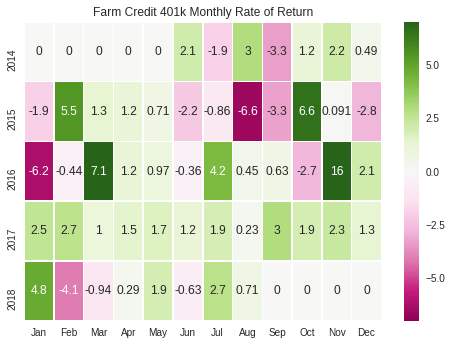

In [44]:
#data frame for grid for heat map
all_fc_df = investment_df[(investment_df.company == 'Farm Credit') & (investment_df.type == '401k')]

#distinct list of values for map
years      = all_fc_df.tran_year.unique()
month_num  = all_fc_df.tran_month.unique()
month_name = all_fc_df.tran_month_name.unique()
current_year = now.year
current_month = now.month

#Creating the empty grid
row = int(len(years))
column = int(len(month_num))
A = np.zeros([row,column], dtype="float64")


#filling in the grid
for x in range(0, row):
  c_year = years[x]
  for y in range(0,column):
    c_month = month_num[y]
    a = all_fc_df[(all_fc_df.tran_year == c_year) & (all_fc_df.tran_month == c_month)].mror
    A[x,y] = a #updating grid with current ROR 
    

#grid settings
#df = pd.DataFrame(A, columns=current_month)

#print(all_fc_df)

#print(A)

#showing the grid    
ax = sns.heatmap(A, linewidth=0.5, annot=True, robust=True, square=False, xticklabels=month_name, yticklabels=years, cmap="PiYG")
ax.set_title('Farm Credit 401k Monthly Rate of Return')

plt.show()

In [81]:
#farm credit 401k ytd rate of return.
print(year0)
print(month0)

fc_df= investment_df[['company','type','tran_year','mror']][(investment_df.company == 'Farm Credit') & (investment_df.type == '401k')]

#df[['a','b']]

#print(fc_df.agg({'mror':'sum'}))

#fc_df_grouped = fc_df.groupby(['company','type','tran_year'])
#print(fc_df_grouped.aggregate(np.sum))

#year_ror_fc_df = fc_df.groupby(['company', 'type','tran_year','mror'])

#print(year_ror_fc_df)

#grouped = df.groupby(['A', 'B'])
#grouped.aggregate(np.sum)


#year_ror_fc_df.aggregate(np.sum)

#fc_aggs  = current_year_fc_df.agg({'begin_balance' : ['sum'], 'end_balance' : ['sum'], 'contributions': ['sum'], 'mror':['sum']})

#fc_aggs['ytd_ror']   = np.round((((fc_aggs.end_balance - fc_aggs.begin_balance - fc_aggs.contributions)/(fc_aggs.end_balance - fc_aggs.contributions))*100),decimals=3)


#print(fc_aggs)




test = fc_df.groupby(['company', 'type','tran_year']).agg({'mror':'sum'})



#test.add_suffix('_mror').reset_index()

print(test)  
  
  
test1 =  pd.DataFrame({'sum' : fc_df.groupby( [ "company", "type",'tran_year'] ).size()}).reset_index()  
  
  
print(test1)


test2 = fc_df.groupby( [ "company", "type",'tran_year']).agg({'mror':'sum'})
                       
                       #.size()}).reset_index()

#test2 = pd.DataFrame({test2.size()}).reset_index()    
    
    
print(test2.size())


2018
8
                              mror
company     type tran_year        
Farm Credit 401k 2014        3.637
                 2015       -2.195
                 2016       23.039
                 2017       21.171
                 2018        4.840
       company  type  tran_year  sum
0  Farm Credit  401k       2014   12
1  Farm Credit  401k       2015   12
2  Farm Credit  401k       2016   12
3  Farm Credit  401k       2017   12
4  Farm Credit  401k       2018   12


TypeError: ignored

# ***Farm Credit HSA Heat Map***

[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00         -inf
   1.20000e-02 -1.56337e+02 -0.00000e+00  0.00000e+00  1.80000e-02
   0.00000e+00 -0.00000e+00]
 [-0.00000e+00  0.00000e+00 -2.41200e+00 -2.56630e+01 -5.20000e+00
  -0.00000e+00  2.00000e-03  1.00000e-03  0.00000e+00  2.00000e-03
  -1.32300e+00 -2.29100e+00]
 [-5.48400e+00 -4.91000e-01  2.70400e+00  1.06800e+00 -3.30739e+02
  -4.00000e-02  2.10000e-02 -1.62000e-01 -2.07000e-01 -1.77100e+00
   2.04100e+00 -8.92000e-01]
 [ 1.74700e+00  2.00700e+00  6.35000e-01  9.94000e-01  3.74000e-01
  -2.74410e+01 -3.52200e+00 -2.08700e+00 -2.66930e+01 -1.22600e+00
   2.38200e+00 -1.85700e+00]
 [ 4.63100e+00 -5.30000e-01 -4.80400e+00  2.31900e+00 -1.10000e+00
   5.91000e-01  2.82400e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00]]


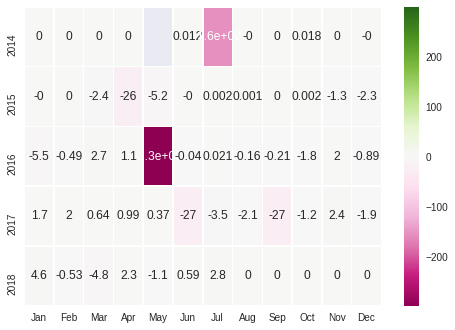

In [11]:
#data frame for grid for heat map
fc_hsa_df = investment_df[(investment_df.company == 'Farm Credit') & (investment_df.type == 'HSA')]

#distinct list of values for map
years      = fc_hsa_df.tran_year.unique()
month_num  = fc_hsa_df.tran_month.unique()
month_name = fc_hsa_df.tran_month_name.unique()
current_year = now.year
current_month = now.month

#Creating the empty grid
row = int(len(years))
column = int(len(month_num))
A = np.zeros([row,column], dtype="float64")


#filling in the grid
for x in range(0, row):
  c_year = years[x]
  for y in range(0,column):
    c_month = month_num[y]
    a = fc_hsa_df[(fc_hsa_df.tran_year == c_year) & (fc_hsa_df.tran_month == c_month)].mror
    A[x,y] = a #updating grid with current ROR 
    

#grid settings
#df = pd.DataFrame(A, columns=current_month)

#print(fc_hsa_df)

print(A)

#showing the grid    
ax = sns.heatmap(A, linewidth=0.5, annot=True, robust=True, square=False, xticklabels=month_name, yticklabels=years, cmap="PiYG")

plt.show()

In [21]:
#Getting past three years of data for all investments
past_investment_df = investment_df[(investment_df.tran_year.isin([year0, year1, year2]))]

#Farm Credit 401k Data
all_fc_df = investment_df[(investment_df.company == 'Farm Credit') & (investment_df.type == '401k')]

fc_df = past_investment_df[(past_investment_df.company == 'Farm Credit') & (past_investment_df.type == '401k')]
fc_df_y0 = fc_df[(fc_df.tran_year == year0)][['mror','tran_month','tran_month_name']]
fc_df_y1 = fc_df[(fc_df.tran_year == year1)][['mror','tran_month','tran_month_name']]
fc_df_y2 = fc_df[(fc_df.tran_year == year2)][['mror','tran_month','tran_month_name']]

#Farm Credit HSA Data
hsa_df = past_investment_df[(past_investment_df.company == 'Farm Credit') & (investment_df.type == 'HSA')]
hsa_df_y0 = hsa_df[(hsa_df.tran_year == year0)][['mror','tran_month','tran_month_name']]
hsa_df_y1 = hsa_df[(hsa_df.tran_year == year1)][['mror','tran_month','tran_month_name']]
hsa_df_y2 = hsa_df[(hsa_df.tran_year == year2)][['mror','tran_month','tran_month_name']]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



### ***Farm Credit Past Three Years of Monthly Rate of Return***

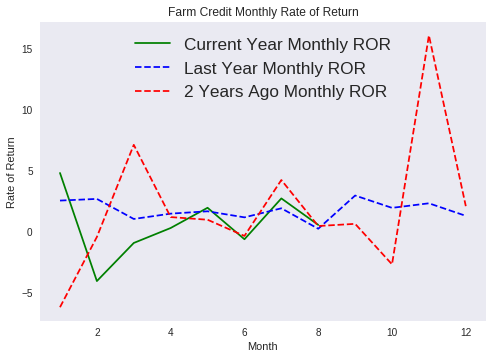

In [284]:
#current year
x0 = fc_df_y0[['tran_month']]
y0 = fc_df_y0[['mror']]
#last year
x1 = fc_df_y1[['tran_month']]
y1 = fc_df_y1[['mror']]
#two years ago
x2 = fc_df_y2[['tran_month']]
y2 = fc_df_y2[['mror']]


#plotting out graph
fig, ax = plt.subplots()
ax.plot(x0, y0, 'k'  , color='green', label = 'Current Year Monthly ROR')
ax.plot(x1, y1, 'k--', color='blue' , label = 'Last Year Monthly ROR')
ax.plot(x2, y2, 'k--', color='red'  , label = '2 Years Ago Monthly ROR')

ax.set(xlabel='Month', ylabel='Rate of Return',title='Farm Credit Monthly Rate of Return')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
ax.grid()

#fig.savefig("FC_ror.png")
plt.show()

# **Heat Map**

     begin_balance      company  contributions  end_balance first_of_month  \
0             1.00  Farm Credit         164.61       164.52     2014-04-01   
1           164.52  Farm Credit       19489.99     19904.11     2014-05-01   
2         19904.11  Farm Credit        1000.00     21322.68     2014-06-01   
3         21322.68  Farm Credit        1000.00     21922.48     2014-07-01   
4         21922.48  Farm Credit        1000.00     23591.30     2014-08-01   
5         23591.30  Farm Credit        1000.00     23835.09     2014-09-01   
6         23835.09  Farm Credit        1000.00     25121.05     2014-10-01   
7         25121.05  Farm Credit        1000.00     26677.28     2014-11-01   
8         26677.28  Farm Credit         500.00     27308.31     2014-12-01   
9         27308.31  Farm Credit        1000.00     27791.49     2015-01-01   
10        27791.49  Farm Credit        1000.00     30397.70     2015-02-01   
11        30397.70  Farm Credit        1300.90     32111.62     

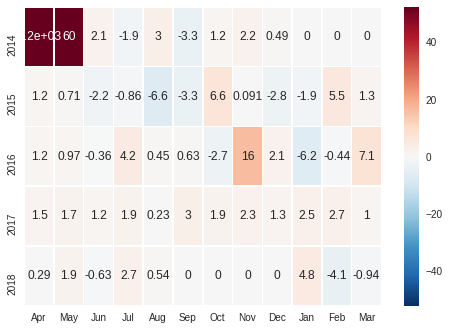

In [22]:
import skimage
import random
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#distinct list of values for map
years      = all_fc_df.tran_year.unique()
month_num  = all_fc_df.tran_month.unique()
month_name = all_fc_df.tran_month_name.unique()
current_year = now.year
current_month = now.month

#Creating the empty grid
row = int(len(years))
column = int(len(month_num))
A = np.zeros([row,column], dtype="float64")


#filling in the grid
for x in range(0, row):
  c_year = years[x]
  for y in range(0,column):
    c_month = month_num[y]
    #future months will always be 0 otherwise grab the ror
    if c_month > current_month and c_year == current_year:
      a = 0
    elif c_month <= 3 and c_year == 2014:
      a = 0
    else:
      a = all_fc_df[(all_fc_df.tran_year == c_year) & (all_fc_df.tran_month == c_month)].mror
  
    A[x,y] = a #updating grid with current ROR 
    

#grid settings
#df = pd.DataFrame(A, columns=current_month)

print(all_fc_df)

#showing the grid    
ax = sns.heatmap(A, linewidth=0.5, annot=True, robust=True, square=False, xticklabels=month_name, yticklabels=years)

#ax.set_xticketlabels(ax.get_xticklabels(), rotation=90)

plt.show()

## ***Farm Credit HSA Monthly Rate of Return***

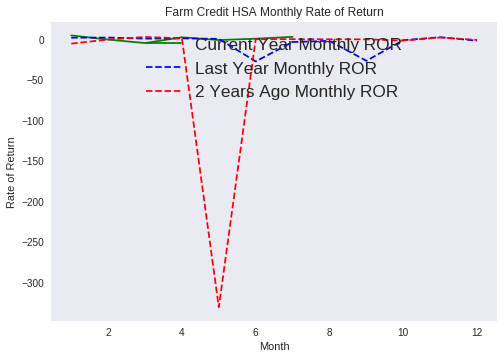

In [271]:
#current year
x0 = hsa_df_y0[['tran_month']]
y0 = hsa_df_y0[['mror']]
#last year
x1 = hsa_df_y1[['tran_month']]
y1 = hsa_df_y1[['mror']]
#two years ago
x2 = hsa_df_y2[['tran_month']]
y2 = hsa_df_y2[['mror']]


#plotting out graph
fig, ax = plt.subplots()
ax.plot(x0, y0, 'k'  , color='green', label = 'Current Year Monthly ROR')
ax.plot(x1, y1, 'k--', color='blue' , label = 'Last Year Monthly ROR')
ax.plot(x2, y2, 'k--', color='red'  , label = '2 Years Ago Monthly ROR')

ax.set(xlabel='Month', ylabel='Rate of Return',title='Farm Credit HSA Monthly Rate of Return')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
ax.grid()

#fig.savefig("FC_ror.png")
plt.show()